# Comparison with Empirical Bayes

In [196]:
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from regain.covariance import graph_lasso_
from regain.covariance import latent_graph_lasso_; reload(latent_graph_lasso_);

In [151]:
import numpy as np
def write_network(K, names, filename):
    import csv
    with open(filename, 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        for i in range(K.shape[0]):
            for j in range(i+1, K.shape[1]):
                writer.writerow([names[i], names[j], np.abs(K[i,j])])
                writer.writerow([names[j], names[i], np.abs(K[j,i])])

def read_network(filename, threshold=1.):
    nn = pd.read_csv(filename, delimiter="\t", header=None)
    columns = sorted(nn[0].unique())
    n_top_edges = int(nn.shape[0] * threshold / 2.)

    nn = nn.sort_values(2, ascending=False)[:2 * n_top_edges]

    net_julia = pd.DataFrame(columns=columns, index=columns)

    for row in nn.itertuples():
        net_julia.loc[row[1], row[2]] = row[3]

    np.fill_diagonal(net_julia.values, net_julia.sum(axis=1).values)
    return net_julia.fillna(0)

In [197]:
from sklearn.metrics import average_precision_score
from __future__ import division
def structure_error(true, pred, thresholding=False, eps=1e-2, no_diagonal=False):
    # avoid inplace modifications
    true = true.copy()
    pred = pred.copy()

    y_true = squareform(true, checks=None)
    y_pred = squareform(pred, checks=None)

    average_precision = average_precision_score(y_true > 0, y_pred)

    if thresholding:
        pred[np.abs(pred) < eps] = 0
    tn_to_remove = 0
    if no_diagonal:
        if true.ndim > 2:
            true = np.array([t - np.diag(np.diag(t)) for t in true])
            pred = np.array([t - np.diag(np.diag(t)) for t in pred])
            tn_to_remove = np.prod(true.shape[:2])
        else:
            true -= np.diag(np.diag(true))
            pred -= np.diag(np.diag(pred))
            tn_to_remove = true.shape[0]
    true[true != 0] = 1
    pred[pred != 0] = 2
    res = true + pred

    TN = np.count_nonzero((res == 0).astype(float))- tn_to_remove
    FN = np.count_nonzero((res == 1).astype(float))
    FP = np.count_nonzero((res == 2).astype(float))
    TP = np.count_nonzero((res == 3).astype(float))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN)
    miss_rate = FN / (TP + FN) or 1 - recall
    f1 = 2 * precision * recall / (precision + recall) \
        if precision + recall > 0 else 0

    accuracy = (TP + TN) / true.size
    prevalence = (TP + FN) / true.size

    fall_out = FP / (FP + TN) if (FP + TN) > 0 else 1
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 1. - fall_out

    balanced_accuracy = 0.5 * (recall + specificity)
    false_discovery_rate = FP / (TP + FP) if TP + FP > 0 else 1 - precision
    false_omission_rate = FN / (FN + TN) if FN + TN > 0 else 0
    negative_predicted_value = TN / (FN + TN) if FN + TN > 0 else \
        1 - false_omission_rate

    positive_likelihood_ratio = recall / fall_out if fall_out > 0 else 0
    negative_likelihood_ratio = miss_rate / specificity \
        if specificity > 0 else 0
    diagnostic_odds_ratio = \
        positive_likelihood_ratio / negative_likelihood_ratio if \
        negative_likelihood_ratio > 0 else 0

    dictionary = dict(
        tp=TP, tn=TN, fp=FP, fn=FN, precision=precision, recall=recall,
        f1=f1, accuracy=accuracy, false_omission_rate=false_omission_rate,
        fdr=false_discovery_rate, npv=negative_predicted_value,
        prevalence=prevalence, miss_rate=miss_rate, fall_out=fall_out,
        specificity=specificity, plr=positive_likelihood_ratio,
        nlr=negative_likelihood_ratio, dor=diagnostic_odds_ratio,
        balanced_accuracy=balanced_accuracy,
        average_precision=average_precision)
    return dictionary

Compare the results with Julia library

In [198]:
(np.nonzero(squareform(df.values, checks=None))[0].size) / float(squareform(df.values, checks=None).size)

ValueError: The matrix argument must be square.

In [199]:
from itertools import product

# n_genes = 50
# i = 3
# algorithm = 'mi'
# df = pd.read_csv("../simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i), delimiter='\t', index_col=0).T

In [206]:
results = {}

for n_genes, i in product([50, 100], range(1,4)):
    true_network = read_network("../goldstandards/{}_yeast{}.tsv".format(n_genes, i))
    
    for algorithm, threshold in product(['mi','puc'], [0.2, 0.15, 0.1, 0.05]):
        df = read_network("../networks/{}_yeast{}_large_{}.txt".format(n_genes, i, algorithm), threshold=threshold)
        results.setdefault(threshold, []).append(structure_error(true_network.values, df.values,
                                                                 no_diagonal=False)['precision'])

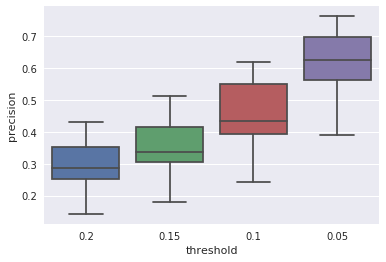

In [207]:
nn = pd.DataFrame(columns=['threshold', 'precision'])
for k, v in results.items():
    for x in v:
        nn = nn.append({'threshold': k, 'precision':x}, ignore_index=True)

bb = nn.copy()
bb['precision'] *= 2

bb = bb.sort_values('threshold', ascending=False)
sns.boxplot(x='threshold', y='precision', data=bb, order=bb.threshold.unique())

In [ ]:
# gl = graph_lasso_.GraphLasso(verbose=0).fit(data)

df = pd.read_csv("../simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i), delimiter='\t', index_col=0).T

In [158]:
lgl = latent_graph_lasso_.LatentGraphLasso(verbose=0).fit(df.values)

In [212]:
results_regain = {}

for n_genes, i in product([50, 100], range(1,4)):
    true_network = read_network("../goldstandards/{}_yeast{}.tsv".format(n_genes, i))
    df = pd.read_csv("../simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i),
                         delimiter='\t', index_col=0).T    
    for alpha, tau in product([0.01, 0.1, 0.5, 0.75, 1], np.logspace(-2,0,5)):
#         df = read_network("../networks/{}_yeast{}_large_{}.txt".format(n_genes, i, algorithm), threshold=threshold)
        lgl = latent_graph_lasso_.LatentGraphLasso(verbose=0, alpha=alpha, tau=tau).fit(df.values)
        results_regain.setdefault(alpha, []).append(structure_error(true_network.values, lgl.precision_,
                                                                thresholding=True, eps=1e-8,
                                                                 no_diagonal=False)['precision'])

In [213]:
nn = pd.DataFrame(columns=['alpha', 'precision'])
for k, v in results_regain.items():
    for x in v:
        nn = nn.append({'alpha': k, 'precision':x}, ignore_index=True)

cc = nn.copy()
# bb['precision'] *= 2

cc = cc.sort_values('alpha', ascending=True)

In [209]:
results_gl = {}

for n_genes, i in product([50, 100], range(1,4)):
    true_network = read_network("../goldstandards/{}_yeast{}.tsv".format(n_genes, i))
    df = pd.read_csv("../simulated_datasets/{}_yeast{}_large.txt".format(n_genes, i),
                         delimiter='\t', index_col=0).T    
    for alpha in ([0.01, 0.1, 0.5, 0.75, 1]):
#         df = read_network("../networks/{}_yeast{}_large_{}.txt".format(n_genes, i, algorithm), threshold=threshold)
        gl = graph_lasso_.GraphLasso(verbose=0, alpha=alpha).fit(df.values)
        results_gl.setdefault(alpha, []).append(structure_error(true_network.values, gl.precision_,
                                                                thresholding=True, eps=1e-8,
                                                                 no_diagonal=False)['precision'])

In [210]:
nn = pd.DataFrame(columns=['alpha', 'precision'])
for k, v in results_gl.items():
    for x in v:
        nn = nn.append({'alpha': k, 'precision':x}, ignore_index=True)

dd = nn.copy()
# bb['precision'] *= 2

dd = dd.sort_values('alpha', ascending=True)

An advantage in taking into account latent variables is visible in the following.

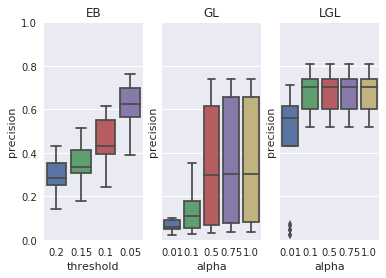

In [223]:
f, ax = plt.subplots(1, 3, sharey=True)
sns.boxplot(x='threshold', y='precision', data=bb, order=bb.threshold.unique(), ax=ax[0])
ax[0].set_title("EB")
sns.boxplot(x='alpha', y='precision', data=dd, order=dd.alpha.unique(), ax=ax[1])
ax[1].set_title("GL")
sns.boxplot(x='alpha', y='precision', data=cc, order=cc.alpha.unique(), ax=ax[2])
ax[2].set_title("LGL")

plt.ylim([0, 1]);

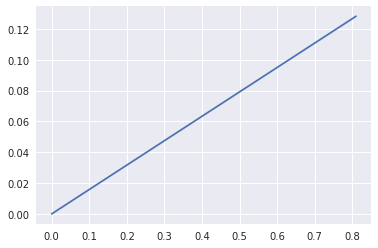

In [195]:
fall_out = [utils.structure_error(true_network.values, lgl.precision_+1e-16,
                      thresholding=True, eps=e, no_diagonal=0)['precision']
       for e in np.logspace(-5,2,100)]
recall = [utils.structure_error(true_network.values, lgl.precision_+1e-16,
                      thresholding=True, eps=e, no_diagonal=0)['recall']
       for e in np.logspace(-5,2,100)]

plt.plot(fall_out, recall)